# Credit Rep Allocation Project

This notebook demonstrates how to perform **Level 1 Allocation** for a set of customer accounts.
We will use a rule-based approach to assign each account to a required experience level
(High, Medium, Low, or Digital) based on:
1. Sales Account Type (High/Medium/Low)
2. Payer Type (Regular/Non-Regular)

Then, we will validate and visualize the results.
After that to maintain the cohesiveness we have solve 2nd Level allocation in this notebook.
Lets deep dive :

In [119]:
# Lets import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
%matplotlib inline

In [120]:
# Now Load the dataset:
df = pd.read_excel('/content/AR Allocation_Final.xlsx', sheet_name='Input_Data')


In [121]:
# Now see the loaded data
df.head()

,Account,Sales L18M,Average Yearly Sales,Existing Credit Rep. No.,New Holding Group,Payer Type As Per Holding Group,Sales Account Type,Level 1 Allocation,Level 2 Allocation
0,1,54267,36178,25,26,Regular Payer,Medium,NaN,NaN
1,2,2326,1551,25,26,Regular Payer,Medium,NaN,NaN
2,3,588349,392233,3,30,Non Regular Payer,High,NaN,NaN
3,4,259558,173039,3,30,Non Regular Payer,High,NaN,NaN
4,5,227151,151434,3,30,Non Regular Payer,High,NaN,NaN


## 4. Exploratory Data Analysis (EDA)

In this section, we'll check data structure, look for missing values,
and summarize key columns (like Sales Account Type, Payer Type, etc.).


In [122]:
#For basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Account                          4024 non-null   int64  
 1   Sales L18M                       4024 non-null   int64  
 2   Average Yearly Sales             4024 non-null   object 
 3   Existing Credit Rep. No.         4024 non-null   int64  
 4   New Holding Group                4024 non-null   int64  
 5   Payer Type As Per Holding Group  4024 non-null   object 
 6   Sales Account Type               4024 non-null   object 
 7   Level 1 Allocation               0 non-null      float64
 8   Level 2 Allocation               0 non-null      float64
dtypes: float64(2), int64(4), object(3)
memory usage: 283.1+ KB


In [123]:
# Check for null values
df.isnull().sum()

,0
Account,0
Sales L18M,0
Average Yearly Sales,0
Existing Credit Rep. No.,0
New Holding Group,0
Payer Type As Per Holding Group,0
Sales Account Type,0
Level 1 Allocation,4024
Level 2 Allocation,4024


In [124]:
## We can see in the above cell that there in no null present in data so, the input data has no missing values(Level 1 Allocation and Level2 Allocation are the columns which we have fill)


In [125]:
 #Basic summary statistics
df.describe(include='all')

,Account,Sales L18M,Average Yearly Sales,Existing Credit Rep. No.,New Holding Group,Payer Type As Per Holding Group,Sales Account Type,Level 1 Allocation,Level 2 Allocation
count,4024.00000,4.024000e+03,4024.0,4024.000000,4024.000000,4024,4024,0.0,0.0
unique,NaN,NaN,3092.0,NaN,NaN,2,3,NaN,NaN
top,NaN,NaN,195.0,NaN,NaN,Non Regular Payer,Low,NaN,NaN
freq,NaN,NaN,13.0,NaN,NaN,2081,1866,NaN,NaN
mean,2012.50000,3.783274e+04,NaN,23.310139,13303.344930,NaN,NaN,NaN,NaN
std,1161.77307,3.354617e+05,NaN,12.638523,7613.022199,NaN,NaN,NaN,NaN
min,1.00000,-1.750180e+05,NaN,0.000000,26.000000,NaN,NaN,NaN,NaN
25%,1006.75000,7.757500e+02,NaN,14.000000,6480.000000,NaN,NaN,NaN,NaN
50%,2012.50000,3.001000e+03,NaN,24.000000,14205.000000,NaN,NaN,NaN,NaN
75%,3018.25000,1.373225e+04,NaN,35.000000,21096.250000,NaN,NaN,NaN,NaN


In [126]:
## Since our data is ready for Apply Level 1 Allocation Rules So, lets proceed further

##  Level 1 Allocation

We have the following matrix:

| Sales Account Type (SA) | Payer Type As Per Holding Group (PHG)      | Allocation                |
|---------------|--------------------|---------------------------|
| High          | Non Regular Payer      | High Experience CR        |
| High          | Regular Payer          | Medium Experience CR      |
| Medium        | Non Regular Payer        | High Experience CR        |
| Medium        | Regular Payer            | Low Experience CR         |
| Low           | Non Regular Payer        | Medium Experience CR      |
| Low           | Regular Payer            | Low Experience CR/Digital |

We'll use a function that maps `(SA, PHG)` to the correct experience level.


In [127]:
# Lets Define allocation function
# As we can see in the question it is mostly looks like a Rule based approach so, we will formulate a rule that question.

def get_level1_allocation(sales_type, payer_type):
    """
    Here we will rule based matrix to find out the  Level 1 Allocation for each Account in data .
    """
    if (sales_type == 'High') and (payer_type == 'Non Regular Payer'):
        return 'High Experience CR'
    elif (sales_type == 'High') and (payer_type == 'Regular Payer'):
        return 'Medium Experience CR'
    elif (sales_type == 'Medium') and (payer_type == 'Non Regular Payer'):
        return 'High Experience CR'
    elif (sales_type == 'Medium') and (payer_type == 'Regular Payer'):
        return 'Low Experience CR'
    elif (sales_type == 'Low') and (payer_type == 'Non Regular Payer'):
        return 'Medium Experience CR'
    elif (sales_type == 'Low') and (payer_type == 'Regular Payer'):
        return 'Low Experience CR'
    else:
        return 'Unknown'



In [128]:
# Now Apply the function to each row
df['Level 1 Allocation'] = df.apply(
    lambda row: get_level1_allocation(row['Sales Account Type'], row['Payer Type As Per Holding Group']),
    axis=1
)




In [129]:
 #Check the distribution
df['Level 1 Allocation'].value_counts()

,count
Level 1 Allocation,
Low Experience CR,1807
High Experience CR,1215
Medium Experience CR,1002


##  Validation & Visualization

Let's verify our Level 1 Allocation by seeing how many accounts fall into each category
and whether it matches our expectations (e.g., do high-value accounts typically go to High Experience?).


Level 1 Allocation
Low Experience CR       1807
High Experience CR      1215
Medium Experience CR    1002
Name: count, dtype: int64


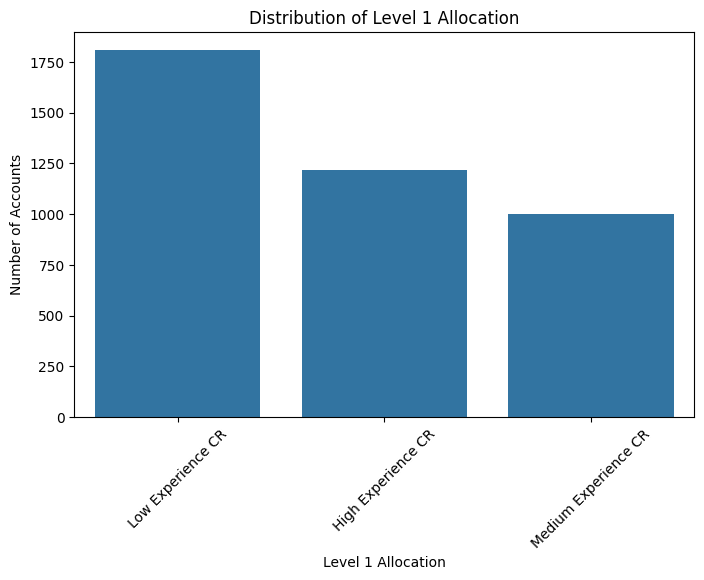

In [130]:
#Plot a count plot
#  Count of accounts per Level 1 Allocation

allocation_counts = df['Level 1 Allocation'].value_counts()
print(allocation_counts)
plt.figure(figsize=(8, 5))
sns.countplot(x='Level 1 Allocation', data=df, order=allocation_counts.index)
plt.title("Distribution of Level 1 Allocation")
plt.xlabel("Level 1 Allocation")
plt.ylabel("Number of Accounts")
plt.xticks(rotation=45)
plt.show()

In [131]:
avg_sales_per_allocation = df.groupby('Level 1 Allocation')['Sales L18M'].mean()
avg_sales_per_allocation.sort_values(ascending=False)

,Sales L18M
Level 1 Allocation,
High Experience CR,66426.493827
Low Experience CR,29004.675152
Medium Experience CR,19081.138723


##  Now Append the Level Allocation in our Excel

> Add blockquote



As we need the updated data with the new 'Level 1 Allocation' column,
we will export it back to Excel for further analysis i.e for Level 2 allocation. So, lets Add it.


In [132]:

df.to_excel("mydata_level1_updated.xlsx", sheet_name="Level1_Updated", index=False)


In [133]:
#

In [134]:
print(df)

      Account  Sales L18M Average Yearly Sales  Existing Credit Rep. No.  \
0           1       54267                36178                        25   
1           2        2326                 1551                        25   
2           3      588349               392233                         3   
3           4      259558               173039                         3   
4           5      227151               151434                         3   
...       ...         ...                  ...                       ...   
4019     4020        -181                 -121                         2   
4020     4021        -400                 -267                         2   
4021     4022        -539                 -360                         2   
4022     4023        1974                 1316                        33   
4023     4024         292                  194                        35   

      New Holding Group Payer Type As Per Holding Group Sales Account Type  \
0        

# Part 2: Level 2 Allocation

In [135]:
### List of 26 rep. id

# Existing Credit Rep. No.	Status
# 4	Low Experience
# 6	Medium Experience
# 12	High Experience
# 14	Low Experience
# 15	Medium Experience
# 19	High Experience
# 20	Low Experience
# 21	Medium Experience
# 24	High Experience
# 25	Low Experience
# 26	Medium Experience
# 27	High Experience
# 32	Low Experience
# 33	Medium Experience
# 34	High Experience
# 35	Low Experience
# 37	Medium Experience
# 38	High Experience
# 40	Low Experience
# 41	Medium Experience
# 42	High Experience
# 43	Low Experience
# 44	Medium Experience
# 46	High Experience
# 47	Low Experience
# 48	Medium Experience

In [136]:
# As per my understanding lets breakdown it part by part for easy understanding
# Group by 'New Holding Group' AND 'Level 1 Allocation'
#  so we know which experience level that group needs.
import pandas as pd
grouped = df.groupby(['New Holding Group', 'Level 1 Allocation'], as_index=False).agg({
    'Account': 'count',
    'Sales L18M': 'sum'
})

grouped.rename(columns={
    'Account': 'NumAccounts',
    'Sales L18M': 'TotalSales'
}, inplace=True)

grouped.head()


,New Holding Group,Level 1 Allocation,NumAccounts,TotalSales
0,26,Low Experience CR,2,56593
1,30,High Experience CR,34,1708327
2,95,Low Experience CR,1,449771
3,218,Low Experience CR,11,211898
4,266,Low Experience CR,2,42149


In [137]:
#  One of the EdgeCase was there is might be chance that in one 'New Holding Group' may be there is account which needs different Experienced CR.
#  Check for duplicates in 'New Holding Group' column of the 'grouped' DataFrame
duplicates = grouped['New Holding Group'].duplicated()
print(grouped[duplicates])

Empty DataFrame
Columns: [New Holding Group, Level 1 Allocation, NumAccounts, TotalSales]
Index: []


In [138]:
# Since there is no duplicacy in 'New Holding Group', So, lets seggregate on the basis of Experience
df_high   = grouped[grouped['Level 1 Allocation'] == 'High Experience CR'].copy()
df_medium = grouped[grouped['Level 1 Allocation'] == 'Medium Experience CR'].copy()
df_low    = grouped[grouped['Level 1 Allocation'].str.contains('Low Experience CR')].copy()


In [139]:
df_high

,New Holding Group,Level 1 Allocation,NumAccounts,TotalSales
1,30,High Experience CR,34,1708327
24,662,High Experience CR,31,236243
79,1915,High Experience CR,32,241742
104,2435,High Experience CR,61,2588400
111,2584,High Experience CR,33,1485816
167,3891,High Experience CR,66,1171370
233,5346,High Experience CR,51,929622
278,6340,High Experience CR,29,1692074
287,6480,High Experience CR,35,399488
305,6933,High Experience CR,40,572789


In [140]:
# Create a dataframe of given credit_reps
credit_reps = {
    4:  "Low Experience",
    6:  "Medium Experience",
    12: "High Experience",
    14: "Low Experience",
    15: "Medium Experience",
    19: "High Experience",
    20: "Low Experience",
    21: "Medium Experience",
    24: "High Experience",
    25: "Low Experience",
    26: "Medium Experience",
    27: "High Experience",
    32: "Low Experience",
    33: "Medium Experience",
    34: "High Experience",
    35: "Low Experience",
    37: "Medium Experience",
    38: "High Experience",
    40: "Low Experience",
    41: "Medium Experience",
    42: "High Experience",
    43: "Low Experience",
    44: "Medium Experience",
    46: "High Experience",
    47: "Low Experience",
    48: "Medium Experience"
}


In [141]:
import pandas as pd


credit_reps_df = pd.DataFrame([
    {'RepNo': rep_no, 'Experience': experience}
    for rep_no, experience in credit_reps.items()
])

credit_reps_df.head()


,RepNo,Experience
0,4,Low Experience
1,6,Medium Experience
2,12,High Experience
3,14,Low Experience
4,15,Medium Experience


In [142]:
# Lets Filter out in this as well on the basis of Experience
high_reps   = credit_reps_df[credit_reps_df['Experience'].str.lower() == 'high experience']
medium_reps = credit_reps_df[credit_reps_df['Experience'].str.lower() == 'medium experience']
low_reps    = credit_reps_df[credit_reps_df['Experience'].str.lower() == 'low experience']


In [143]:
print("High Reps:\n", high_reps, "\n")
print("Medium Reps:\n", medium_reps, "\n")
print("Low Reps:\n", low_reps, "\n")


High Reps:
     RepNo       Experience
2      12  High Experience
5      19  High Experience
8      24  High Experience
11     27  High Experience
14     34  High Experience
17     38  High Experience
20     42  High Experience
23     46  High Experience 

Medium Reps:
     RepNo         Experience
1       6  Medium Experience
4      15  Medium Experience
7      21  Medium Experience
10     26  Medium Experience
13     33  Medium Experience
16     37  Medium Experience
19     41  Medium Experience
22     44  Medium Experience
25     48  Medium Experience 

Low Reps:
     RepNo      Experience
0       4  Low Experience
3      14  Low Experience
6      20  Low Experience
9      25  Low Experience
12     32  Low Experience
15     35  Low Experience
18     40  Low Experience
21     43  Low Experience
24     47  Low Experience 



In [144]:
def level2Allocation(groups_df, reps_df):
    """
    Here we are going to code a simple greedy approach to allocate holding groups to reps. and groups_df is a DataFrame with columns [New Holding Group, NumAccounts, TotalSales].
    and reps_df is a DataFrame with columns [RepNo, Experience].
     Returns: A DataFrame with each group's assigned rep.
    """

    groups_df_sorted = groups_df.sort_values(by='TotalSales', ascending=False).copy()
    groups_df_sorted.reset_index(drop=True, inplace=True)

    rep_tracker = {}
    for rep_no in reps_df['RepNo']:
        rep_tracker[rep_no] = {
            'assigned_sales': 0,
            'assigned_accounts': 0
        }

    assignments = []

    for idx, row in groups_df_sorted.iterrows():
        best_rep = None
        min_load = None

        for rep_no, info in rep_tracker.items():
            current_load = info['assigned_sales']

            if (min_load is None) or (current_load < min_load):
                min_load = current_load
                best_rep = rep_no

        rep_tracker[best_rep]['assigned_sales'] += row['TotalSales']
        rep_tracker[best_rep]['assigned_accounts'] += row['NumAccounts']

        assignments.append({
            'New Holding Group': row['New Holding Group'],
            'NumAccounts': row['NumAccounts'],
            'TotalSales': row['TotalSales'],
            'AssignedRep': best_rep
        })

    assignment_df = pd.DataFrame(assignments)

    final_loads = []
    for rep_no, info in rep_tracker.items():
        final_loads.append({
            'RepNo': rep_no,
            'TotalAssignedSales': info['assigned_sales'],
            'TotalAssignedAccounts': info['assigned_accounts']
        })
    final_loads_df = pd.DataFrame(final_loads)

    return assignment_df, final_loads_df


In [145]:
# High Experience Allocation
high_assignments, high_loads = level2Allocation(df_high, high_reps)




In [146]:
# Medium Experience Allocation
med_assignments, med_loads = level2Allocation(df_medium, medium_reps)



In [147]:
# Low Experience Allocation
low_assignments, low_loads = level2Allocation(df_low, low_reps)

In [148]:
final_assignments = pd.concat([high_assignments, med_assignments, low_assignments], ignore_index=True)


In [149]:
df_merged = pd.merge(df,
                    final_assignments[['New Holding Group', 'AssignedRep']],
                    on='New Holding Group'
                    )

df_merged['Level 2 Allocation'] = df_merged['AssignedRep']

df_merged = df_merged.drop('AssignedRep', axis=1)

df_merged.head()


,Account,Sales L18M,Average Yearly Sales,Existing Credit Rep. No.,New Holding Group,Payer Type As Per Holding Group,Sales Account Type,Level 1 Allocation,Level 2 Allocation
0,1,54267,36178,25,26,Regular Payer,Medium,Low Experience CR,4
1,2,2326,1551,25,26,Regular Payer,Medium,Low Experience CR,4
2,3,588349,392233,3,30,Non Regular Payer,High,High Experience CR,46
3,4,259558,173039,3,30,Non Regular Payer,High,High Experience CR,46
4,5,227151,151434,3,30,Non Regular Payer,High,High Experience CR,46


In [151]:

final_agg = df_merged.groupby('Level 2 Allocation').agg({
    'Account': 'count',
    'Sales L18M': 'sum',
    'Level 1 Allocation': lambda x: ', '.join(x.unique())
})
final_agg.rename(columns={'Account': 'TotalAccounts'}, inplace=True)
final_agg



,TotalAccounts,Sales L18M,Level 1 Allocation
Level 2 Allocation,,,
4,190,5825996,Low Experience CR
6,4,5258572,Medium Experience CR
12,38,22321446,High Experience CR
14,212,5826026,Low Experience CR
15,27,3542591,Medium Experience CR
19,67,22039546,High Experience CR
20,200,5826012,Low Experience CR
21,9,3407497,Medium Experience CR
24,157,12759407,High Experience CR


In [171]:
df.to_excel("AR Allocation.xlsx", sheet_name="Level Allocation Updated", index=False)


## Lets Visualise

Text(0.5, 1.0, 'Total L18M Sales by Rep (High Experience CR)')

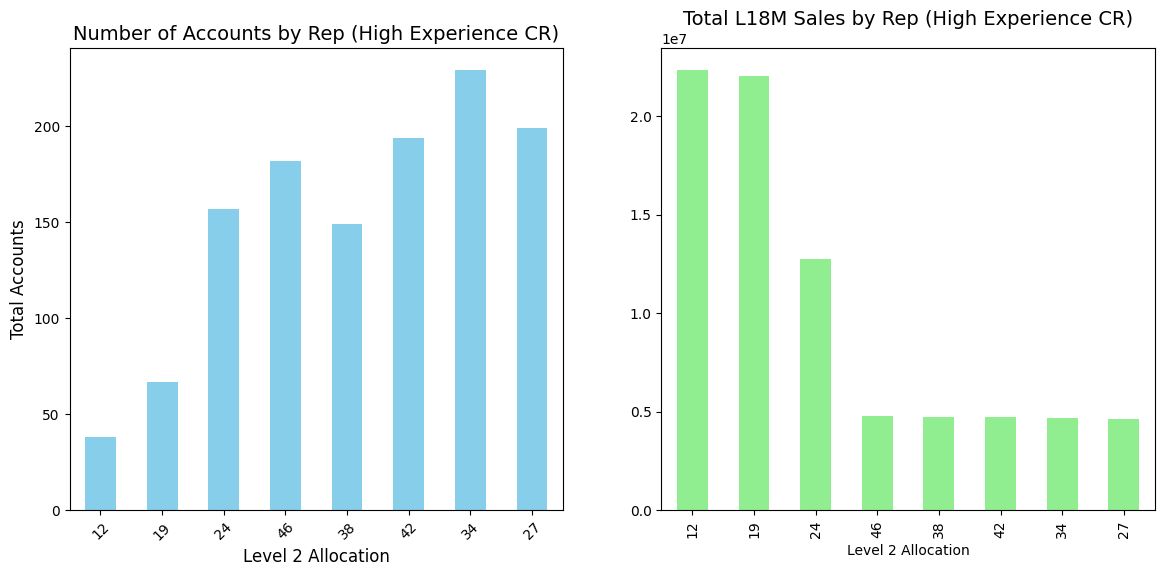

In [160]:
import matplotlib.pyplot as plt

# Filter data for 'High Experience CR'
filtered_data = final_agg[final_agg['Level 1 Allocation'].str.contains('High Experience', na=False)]

filtered_data_sorted = filtered_data.sort_values(by='Sales L18M', ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

filtered_data_sorted['TotalAccounts'].plot(kind='bar', ax=ax[0], color='skyblue')
ax[0].set_title("Number of Accounts by Rep (High Experience CR)", fontsize=14)
ax[0].set_xlabel("Level 2 Allocation", fontsize=12)
ax[0].set_ylabel("Total Accounts", fontsize=12)
ax[0].set_xticklabels(filtered_data_sorted.index, rotation=45)

filtered_data_sorted['Sales L18M'].plot(kind='bar', ax=ax[1], color='lightgreen')
ax[1].set_title("Total L18M Sales by Rep (High Experience CR)", fontsize=14)


Text(0.5, 1.0, 'Total L18M Sales by Rep (Medium Experience CR)')

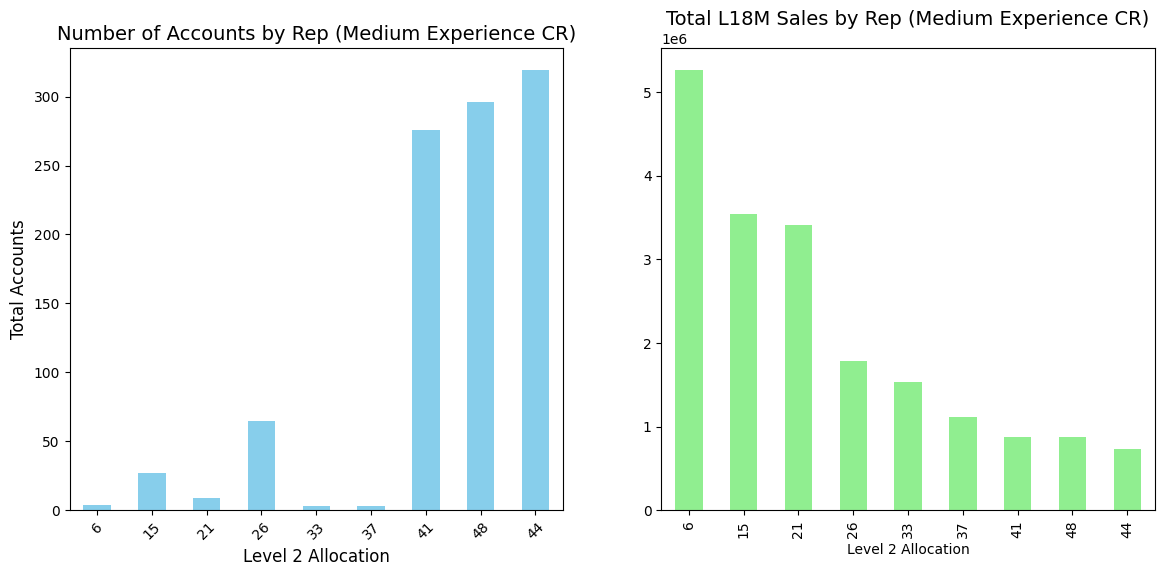

In [161]:
import matplotlib.pyplot as plt

# Filter data for 'High Experience CR'
filtered_data = final_agg[final_agg['Level 1 Allocation'].str.contains('Medium Experience', na=False)]

filtered_data_sorted = filtered_data.sort_values(by='Sales L18M', ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

filtered_data_sorted['TotalAccounts'].plot(kind='bar', ax=ax[0], color='skyblue')
ax[0].set_title("Number of Accounts by Rep (Medium Experience CR)", fontsize=14)
ax[0].set_xlabel("Level 2 Allocation", fontsize=12)
ax[0].set_ylabel("Total Accounts", fontsize=12)
ax[0].set_xticklabels(filtered_data_sorted.index, rotation=45)

filtered_data_sorted['Sales L18M'].plot(kind='bar', ax=ax[1], color='lightgreen')
ax[1].set_title("Total L18M Sales by Rep (Medium Experience CR)", fontsize=14)

Text(0.5, 1.0, 'Total L18M Sales by Rep (Low Experience CR)')

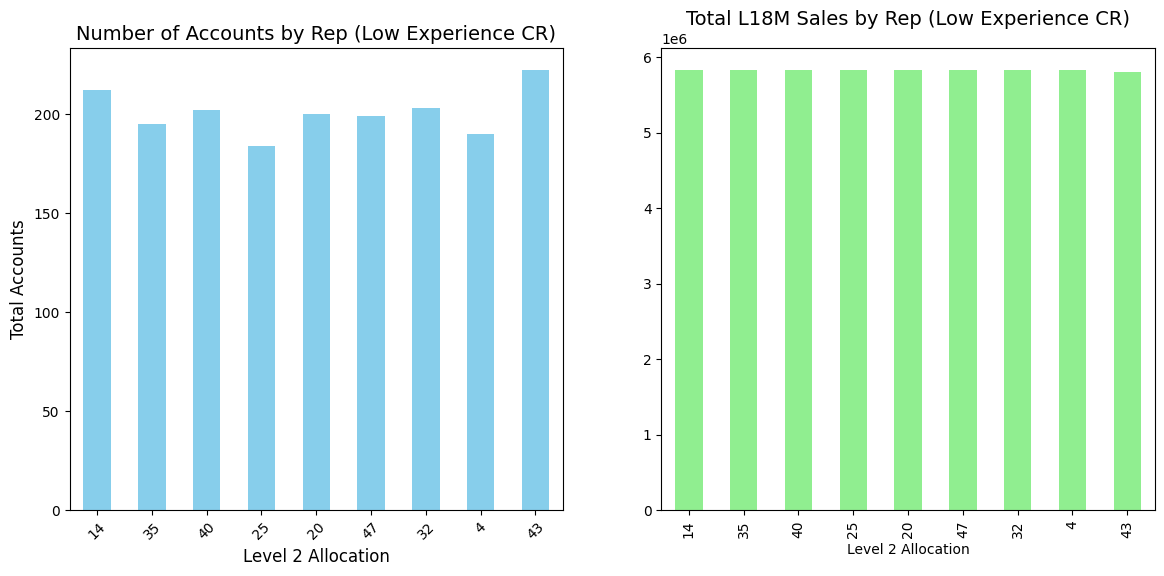

In [162]:
import matplotlib.pyplot as plt

# Filter data for 'High Experience CR'
filtered_data = final_agg[final_agg['Level 1 Allocation'].str.contains('Low Experience', na=False)]

filtered_data_sorted = filtered_data.sort_values(by='Sales L18M', ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

filtered_data_sorted['TotalAccounts'].plot(kind='bar', ax=ax[0], color='skyblue')
ax[0].set_title("Number of Accounts by Rep (Low Experience CR)", fontsize=14)
ax[0].set_xlabel("Level 2 Allocation", fontsize=12)
ax[0].set_ylabel("Total Accounts", fontsize=12)
ax[0].set_xticklabels(filtered_data_sorted.index, rotation=45)

filtered_data_sorted['Sales L18M'].plot(kind='bar', ax=ax[1], color='lightgreen')
ax[1].set_title("Total L18M Sales by Rep (Low Experience CR)", fontsize=14)

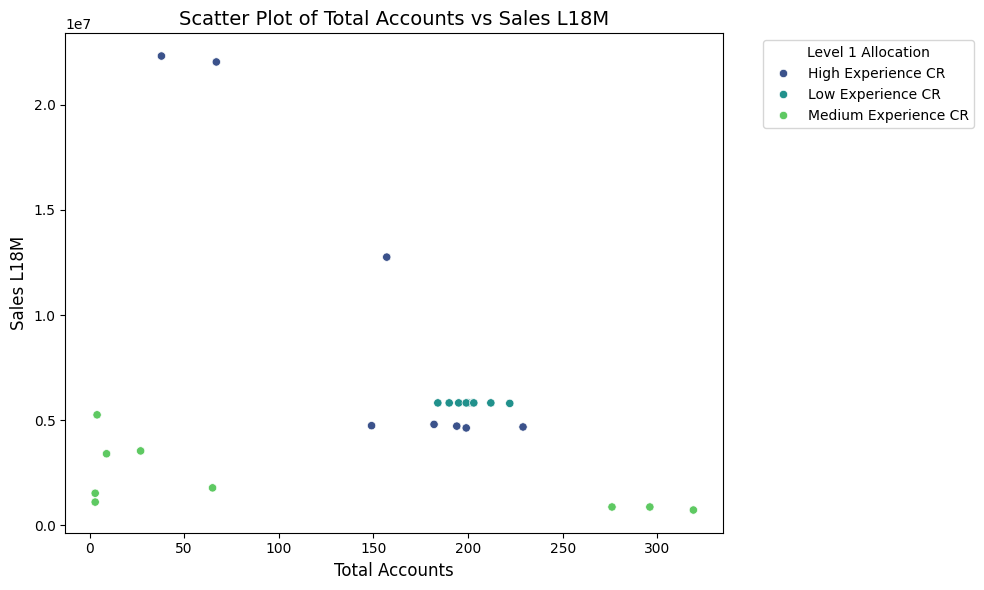

In [170]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort by 'Sales L18M' to ensure consistency
final_agg_sorted = final_agg.sort_values(by='Sales L18M', ascending=False)

# Create a single scatter plot
plt.figure(figsize=(10, 6))  # Adjust figure size

sns.scatterplot(
    x=final_agg_sorted['TotalAccounts'],
    y=final_agg_sorted['Sales L18M'],
    hue=final_agg_sorted['Level 1 Allocation'],
    palette='viridis'
)

plt.title("Scatter Plot of Total Accounts vs Sales L18M", fontsize=14)
plt.xlabel("Total Accounts", fontsize=12)
plt.ylabel("Sales L18M", fontsize=12)


plt.legend(title="Level 1 Allocation", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()




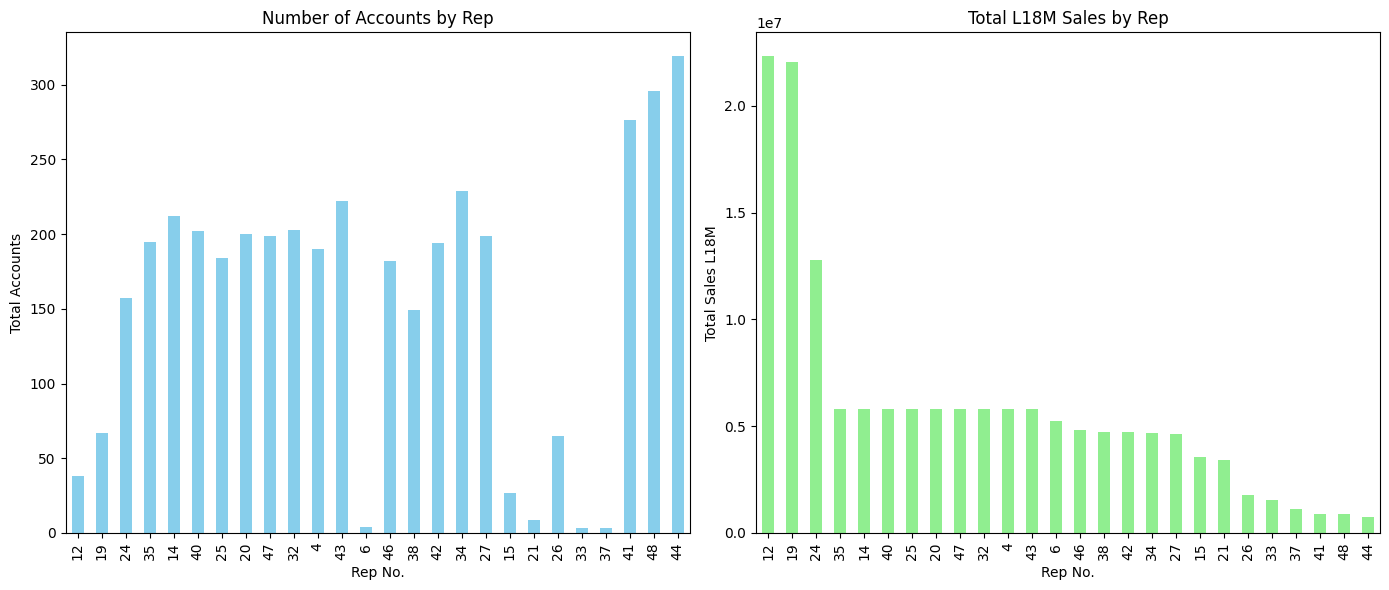

In [157]:

import matplotlib.pyplot as plt

# Sort by total sales to see if distribution is balanced
final_agg_sorted = final_agg.sort_values(by='Sales L18M', ascending=False)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

final_agg_sorted['TotalAccounts'].plot(kind='bar', ax=ax[0], color='skyblue')
ax[0].set_title("Number of Accounts by Rep")
ax[0].set_xlabel("Rep No.")
ax[0].set_ylabel("Total Accounts")

final_agg_sorted['Sales L18M'].plot(kind='bar', ax=ax[1], color='lightgreen')
ax[1].set_title("Total L18M Sales by Rep")
ax[1].set_xlabel("Rep No.")
ax[1].set_ylabel("Total Sales L18M")

plt.tight_layout()
plt.show()


## END